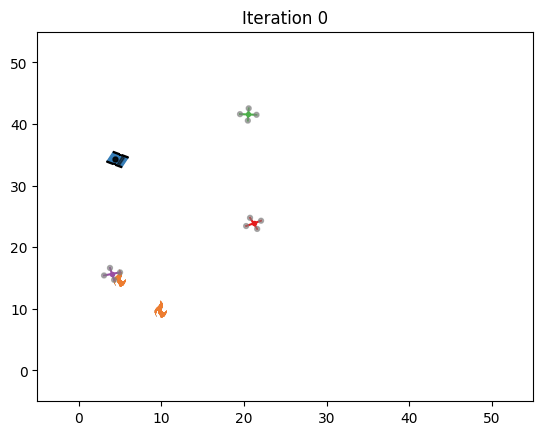

In [191]:
import numpy as np
import matplotlib.pyplot as plt
from palettable.colorbrewer.qualitative import Set1_9
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg

class PlotSim:
    """Class to plot the simulation of agents moving towards a goal."""
    def __init__(self, num_agents, goals, robot_types, completed_task_img, not_completed_task_img, env_size=15, padding=5, scale = 0.5):
        # Initialize plotting objects
        self.fig, self.ax = plt.subplots()
        plt.xlim(-5, env_size + padding)
        plt.ylim(-5, env_size + padding)
        self.scale = scale
        self.cmap = Set1_9.mpl_colors
        self.agent_paths = [self.ax.plot([], [], 'o-', markersize=3, linewidth=1, alpha=0.5, color=self.cmap[i])[0] for i in range(num_agents)]
        self.all_rosbots = []  # List to store all robots
        self.robot_types = robot_types
        self.initial_task_positions = goals  # Store initial task positions
        self.completed_tasks = [False] * len(goals)  # Initialize all tasks as not completed
        self.task_icons = []
        # Load task icons
        self.completed_task_img = OffsetImage(completed_task_img, zoom=scale * 0.3)
        self.not_completed_task_img = OffsetImage(not_completed_task_img, zoom=scale * 0.3)
        # Initialize task icons
        for pos in goals:
            task_icon = AnnotationBbox(self.not_completed_task_img, pos, frameon=False, zorder=1)
            self.ax.add_artist(task_icon)
            self.task_icons.append(task_icon)

    def init(self):
        """Initialize the background of the plot."""
        agent_id = 0
        for agent_path in self.agent_paths:
            agent_path.set_data([], [])
            self.all_rosbots.append(self.init_robot(self.cmap[agent_id], self.robot_types[agent_id]))
            agent_id += 1
        return self.agent_paths

    def update(self, frame, args):
        """Update the plot data for each agent."""
        agent_positions = args['positions'][frame]
        agent_headings = args['headings'][frame]
        task_status = args['goals_completed'][frame]

        # Update plot data for each agent
        for agent_id, agent_path in enumerate(self.agent_paths):
            xnew, ynew = agent_positions[agent_id][:2]
            heading = agent_headings[agent_id]
            robot_type = self.robot_types[agent_id]
            self.update_robot(self.all_rosbots[agent_id], (xnew, ynew), heading, color=self.cmap[agent_id], robot_type=robot_type)
            xdata, ydata = agent_path.get_data()
            xdata = np.append(xdata, xnew)
            ydata = np.append(ydata, ynew)
            agent_path.set_data(xdata, ydata)
                # Update task icons based on task status
        for task_id, completed in enumerate(task_status):
            if completed:
                self.task_icons[task_id].offsetbox = self.completed_task_img
            else:
                self.task_icons[task_id].offsetbox = self.not_completed_task_img
        
        # Update title
        self.ax.set_title(f'Iteration {frame}')
        return self.agent_paths

    def init_robot(self, color='r', robot_type='A'):
        """Initialize parts of the Robot with placeholders for their geometric data"""
        elements = {}

        if robot_type == 'A':  # Ground vehicle
            elements['red_box'] = self.ax.fill([], [], color=color, alpha=1,zorder=2)[0]
            elements['left_tires'] = self.ax.fill([], [], color='k',zorder=2)[0]
            elements['right_tires'] = self.ax.fill([], [], color='k',zorder=2)[0]
            elements['light_bar'] = self.ax.fill([], [], color='k', alpha=0.5,zorder=2)[0]
            elements['lidar'] = self.ax.scatter([], [], color='k', s=30, alpha=0.9,zorder=2)
        
        elif robot_type == 'B':  # Drone
            elements['body'] = self.ax.scatter([], [], color=color, s=30, alpha=1,zorder=3)
            elements['arms'] = [self.ax.plot([], [], color=color, linewidth=5, alpha=1,zorder=2)[0] for _ in range(2)]
            elements['rotors'] = self.ax.scatter([], [], color=[0.5,0.5,0.5], s=30, alpha=0.6,zorder=3)
        return elements

    def update_robot(self, elements, position, heading_ang, color, robot_type='A'):
        """Update the position and orientation of the Robot parts"""
        if robot_type == 'B':  # Update for drone
            wspan = self.scale * 2  # Width of the drone arms
            rot = heading_ang
            center = np.array(position)
            
            pt1 = center + wspan * np.array([np.cos(rot + np.pi / 4), np.sin(rot + np.pi / 4)])
            pt2 = center - wspan * np.array([np.cos(rot + np.pi / 4), np.sin(rot + np.pi / 4)])
            pt3 = center - wspan * np.array([np.cos(rot - np.pi / 4), np.sin(rot - np.pi / 4)])
            pt4 = center + wspan * np.array([np.cos(rot - np.pi / 4), np.sin(rot - np.pi / 4)])

            body = np.array([pt1, pt2, pt3, pt4])
            elements['arms'][0].set_data(body[0:2, 0], body[0:2, 1])
            elements['arms'][1].set_data(body[2:4, 0], body[2:4, 1])
            elements['arms'][0].set_linewidth(3 * self.scale)  # Scale the line width
            elements['arms'][1].set_linewidth(3 * self.scale)  # Scale the line width

            elements['rotors'].set_offsets(body)
            elements['rotors'].set_sizes([self.scale**3 * 100] * 4)  # Scale the scatter size
            elements['body'].set_offsets(center.reshape(1,-1))
            elements['body'].set_facecolor(color)
            elements['body'].set_sizes([60 * self.scale**3])  # Scale the scatter size


        else:  # Update for ground vehicle
            parts = {
                'red_box': np.array([[-2, -2, 2, 2], [1.6, -1.6, -1.6, 1.6]]),
                'left_tires': np.array([
                    [0.35, 0.35, 2, 2, 0.35, -0.35, -2, -2, -0.35, -0.35],
                    [1.6, 1.9, 1.9, 1.6, 1.6, 1.6, 1.6, 1.9, 1.9, 1.6]
                ]),
                'right_tires': np.array([
                    [0.35, 0.35, 2, 2, 0.35, -0.35, -2, -2, -0.35, -0.35],
                    [-1.6, -1.9, -1.9, -1.6, -1.6, -1.6, -1.6, -1.9, -1.9, -1.6]
                ]),
                'light_bar': np.array([[-0.6, -0.6, -1.25, -1.25], [1.2, -1.2, -1.2, 1.2]]),
            }

            rotation = np.array([
                [np.cos(heading_ang), -np.sin(heading_ang)],
                [np.sin(heading_ang), np.cos(heading_ang)]
            ])

            for name, part in parts.items():
                scaled_part = self.scale * part
                transformed = rotation @ scaled_part + np.array(position)[:, None]
                elements[name].set_xy(transformed.T)
                if name == 'red_box':
                    elements[name].set_facecolor(color)  # Apply color only to the ground vehicle parts
            lidar_position = np.array(position) + rotation @ np.array([0.6*self.scale, 0])  # Position in front of the vehicle
            elements['lidar'].set_offsets(lidar_position.reshape(1, -1))  # Update LiDAR position
            elements['lidar'].set_sizes([self.scale**2 * 50])  # Scale the scatter size


# Example usage:
num_agents = 4
goals = [(10, 10), (5, 15)]
robot_types = np.random.choice(['A', 'B'], num_agents)
task_status = np.random.choice([True, False], len(goals))
completed_task_img = mpimg.imread('../figures/puddle_icon.png')
not_completed_task_img = mpimg.imread('../figures/fire_icon.png')
sim = PlotSim(num_agents, goals, robot_types, completed_task_img, not_completed_task_img, env_size=50, padding=5, scale=0.5)
sim.init()

# Assuming you have positions, headings, and robot types data to update:
positions_data = np.random.rand(100, num_agents, 2) * 50  # Example positions data (x, y)
headings_data = np.random.rand(100, num_agents) * 2 * np.pi  # Example headings data

args = {'positions': positions_data, 'headings': headings_data, 'goals_completed': [task_status]}

for frame in range(1):
    sim.update(frame, args)
    plt.pause(0.1)  # Adjust as needed for animation speed

plt.show()
